In [45]:
import numpy as np

from tqdm.notebook import tnrange, tqdm
import matplotlib.pyplot as plt

import re
import os
import pickle

import ase.io as ase_io

import ase.units as ase_units

import sys
sys.path.append('../Functions/')
from my_utilis import random_forces_index, rs_to_gcm3

In [46]:
au_to_angstrom = 0.529177249
Ry_to_eV = ase_units.Ry  #13.605703976

## Check if units are correct

Desired units 
* cell length: angstrom 
* positions: angstrom 
* energy: eV 
* forces: eV/angstrom 

In [54]:
data_path = "../data/data_parac_pbe_small1/"
test_file = data_path+ "T500/rs1.190/scf.250.out"
        
frame = ase_io.read(test_file)

file = open(test_file, "r")
lines = file.readlines()
file.close()

energies=[]
energies_line=[]
for i,line in enumerate(lines):
    
    match_celldim = re.search(r'lattice parameter \(alat\)  =\s+(\d+\.\d+)\s+(\w+\.\w+)', line)
    match_energy = re.search(r"total energy\s+=\s+(-?\d+\.\d+)", line)
    match_position_start = re.search(r'site\s+n\.\s+atom\s+positions', line)
    match_forces_start = re.search(r"Forces\s+acting\s+on\s+atoms", line)
    
    #extract cell dimension
    if match_celldim:
        length = float(match_celldim.group(1))
        print(line)
    
    #extract energy 
    if match_energy:
        energies.append( float(match_energy.group(1)) )
        energies_line.append(i)
     
    #extract position information start
    if match_position_start:
        position_start = i+1
    
    #extract force information start
    if match_forces_start:
        forces_start = i+2
        


# check units of cell dimension
assert( np.abs(frame.cell.lengths()[0] - length * au_to_angstrom) < 1e-5) #au correctly converted to angstrom

# check units of positions
# extract floats from the string
matches = re.findall(r'[-+]?\d*\.\d+', lines[position_start])
positions = np.array([float(match) for match in matches]) #extracts position of first atom
print(lines[position_start-1])
assert(np.all(np.abs(frame.get_positions()[0] - positions * length * au_to_angstrom ) <1e-5) ) #alat correctly converted to angstrom

#check units of energy
print( lines[energies_line[-1] ] )
energy = energies[-1] #take last energy value
assert(np.abs(frame.get_total_energy() - energy * Ry_to_eV) <1e-3) #Ry correctly converted to eV

#check forces
print(lines[forces_start - 2])
matches = re.findall(r'[-+]?\d*\.\d+', lines[forces_start])
forces = np.array([float(match) for match in matches]) 
assert(np.all( np.abs(frame.get_forces()[0] - forces * Ry_to_eV/au_to_angstrom ) <1e-5) ) #Ry/au correctly converted to eV/angstrom



     lattice parameter (alat)  =       9.6674  a.u.

     site n.     atom                  positions (alat units)

!    total energy              =    -121.93030449 Ry

     Forces acting on atoms (cartesian axes, Ry/au):



## load frames and save it

## train set

In [13]:
#data_paths = ["../data/data_parac_pbe_small1/", "../data/data2_pbe/", "../data/data3_pbe/", "../data/NVT_conf/batch1/"]
data_paths = ["../data/data_parac_pbe_small1/"]

In [14]:
Temperature_list=[]
density_list=[]
frames = []
data_index=[]

#loop the different data directories
for d,data_path in enumerate(tqdm(data_paths)):
    Temperatures = os.listdir(data_path)

    #loop for different Temperature folders
    for T in tqdm(Temperatures):
        density_files = os.listdir(data_path + T)

        #loop different density folders
        for d_f in density_files:
            load_path = data_path + f"T{T}/{d_f}"
            configuration_files = os.listdir(data_path + f"{T}/{d_f}/")

            #loop different configuration files
            for conf_file in configuration_files:
                
                if conf_file.endswith(".out"):
                    #read frames and append to the list
                    frame = ase_io.read(data_path + f"{T}/{d_f}/{conf_file}")
                    frames.append(frame)
                    #store Temperature and density just in case we need (density not necessary, since it can be calculated from frames anyways)
                    Temperature_list.append( int(re.search(r'\d+', T).group()) )
                    density_list.append(  float(re.search(f"\d+\.\d+", d_f).group()) )

                    #store in which data group it belonged, in case we need it
                    data_index.append(d)

folder =f"{len(frames)}_frames"
print(folder)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

990_frames


In [15]:
destination_dir = f"../frames_data/{folder}/"
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)
    
## save the frames in extended XYZ format
ase_io.write(f"../frames_data/{folder}/frames.xyz", frames, format="extxyz")
#save density and T info for each frame
np.save(f"../frames_data/{folder}/Temperatures.npy", Temperature_list) #stored as K
np.save(f"../frames_data/{folder}/Densities.npy", density_list) #stored as rs
np.save(f"../frames_data/{folder}/DataIndex.npy", data_index)


## test set

In [ ]:
data_paths = ["../data/data_parac_pbe_small2/"]

In [ ]:
Temperature_list=[]
density_list=[]
frames = []
data_index=[]

for d,data_path in enumerate(tqdm(data_paths)):
    Temperatures = os.listdir(data_path)
    for T in tqdm(Temperatures):
        density_files = os.listdir(data_path + T)
        for d_f in density_files:
            load_path = data_path + f"T{T}/{d_f}"
            configuration_files = os.listdir(data_path + f"{T}/{d_f}/")
            for conf_file in configuration_files:
                if conf_file.endswith(".out"):
                    frame = ase_io.read(data_path + f"{T}/{d_f}/{conf_file}")
                    frames.append(frame)
                    Temperature_list.append( int(re.search(r'\d+', T).group()) )
                    density_list.append(  float(re.search(f"\d+\.\d+", d_f).group()) )
                    data_index.append(d)

In [ ]:
folder="frames_test"

destination_dir = f"../{folder}/frames_test"
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)
    
## save the frames in extended XYZ format
ase_io.write(f"../frames_data/{folder}/frames_test.xyz", frames, format="extxyz")
#save density and T info for each frame
np.save(f"../frames_data/{folder}/Temperatures.npy", Temperature_list) #stored as K
np.save(f"../frames_data/{folder}/Densities.npy", density_list) #stored as rs
np.save(f"../frames_data/{folder}/DataIndex.npy", data_index)


# Force indexes

Create the force indexes and save them

In [8]:
#create and save force indices for train set
frames_folder = "990_frames"
frames = ase_io.read(f"../frames_data/{frames_folder}/frames.xyz", index = ":")

#create fore indexes and save them
Nforces=10
force_idx = random_forces_index(frames, Nforces, seed=10)
np.save(f"../frames_data/{frames_folder}/random_train_{Nforces}indices.npy",force_idx)


In [9]:
#create and save force indices for test set
frames_test = ase_io.read(f"../frames_data/frames_test/frames.xyz", index = ":")

#create fore indexes and save them
Nforces=10
force_idx_test = random_forces_index(frames, Nforces, seed=10)
np.save(f"../frames_data/{frames_folder}/random_train_{Nforces}indices.npy",force_idx_test)

# Distribution Plot

In [41]:
from collections import Counter

def distribution_plot(fig, T_list, rho_list, title=""):
    label_size=13
    tick_size=12
    title_size=15
    
    density_bins = 25
    T_bins= 20

    
    gs = fig.add_gridspec(ncols=3, nrows=3, 
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    
    plt.suptitle(title, size=title_size)
    # Combine Temperature_list and density_list into pairs
    data_pairs = list(zip(T_list, rho_list))
    
    # Calculate the counts of each (Temperature, Density) pair
    point_counts = Counter(data_pairs)
    
    # Convert the Counter dictionary values to a list
    point_counts = np.array([point_counts[pair] for pair in data_pairs])
     
    normalized_sizes = point_counts / np.max(point_counts) *2
    
    # Scatterplot axes
    ax = fig.add_subplot(gs[:2, 1:])
    #histogram axes
    ax_histy = fig.add_subplot(gs[:2, 0])
    ax_histx = fig.add_subplot(gs[-1, 1:])

    #Scatterplot
    ax.scatter(T_list, rho_list,  s=normalized_sizes, c="coral")
    
    xlim = [T_list.min()-500, T_list.max()+500]
    ylim = [rho_list.min()-0.1, rho_list.max()+0.1]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Remove ticks and labels from scatter plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    

    #Histogram
    ax_histx.hist(T_list, bins =T_bins, orientation="vertical", color = "darkorange")
    ax_histx.set_xlabel("Temperature [K]", size=label_size)
    ax_histx.set_xlim(xlim)
    ax_histx.tick_params( labelsize=tick_size)
    
    ax_histx.yaxis.set_label_position("right")
    ax_histx.yaxis.tick_right()
    
    ax_histy.hist(rho_list, bins=density_bins, orientation="horizontal", color="darkorange")
    ax_histy.set_ylabel("Density [$g/cm^3$]", size = label_size)
    ax_histy.set_ylim(ylim)
    ax_histy.tick_params( labelsize=tick_size)
    ax_histy.xaxis.set_label_position("top")
    ax_histy.xaxis.tick_top()
       
    plt.show()

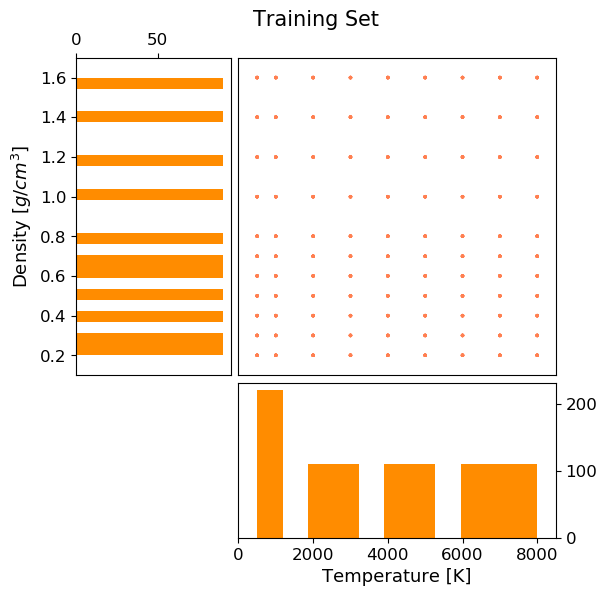

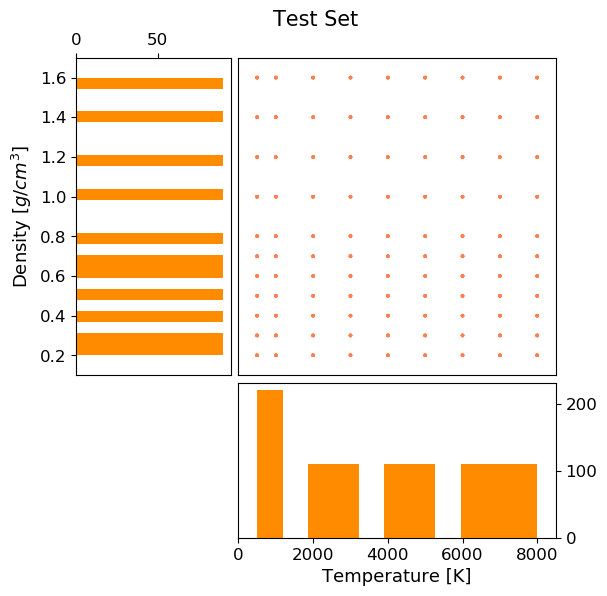

In [42]:
#Training set
folder="990_frames"
T_list =np.load(f"../frames_data/{folder}/Temperatures.npy")
rho_list=rs_to_gcm3(np.load(f"../frames_data/{folder}/Densities.npy"))

#test set
T_list_test =np.load(f"../frames_data/frames_test/Temperatures.npy")
rho_list_test=rs_to_gcm3(np.load(f"../frames_data/frames_test/Densities.npy"))



# Start with a square Figure.
size=(6,6)
fig = plt.figure(figsize=size)
distribution_plot(fig, T_list, rho_list, title="Training Set")
fig = plt.figure(figsize=size)
distribution_plot(fig, T_list_test, rho_list_test, title="Test Set")